# 도마뱀 책 정리 
## 알고리즘 체인과 파이프라인

In [12]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state= 0)

In [13]:
# 훈련 데이터의 최솟값, 최댓값을 계산

scaler = MinMaxScaler().fit(X_train)

# 훈련 데이터 스케일 조정
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련 데이터에 SVM 학습
svm.fit(X_train_scaled, y_train)

# 테스트 데이터의 스케일을 조정하고 점수를 계산
X_test_scaled = scaler.transform(X_test)
print("테스트 점수 : {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수 : 0.95


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Data 전처리와 매개변수 선택

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


- 사이킷런 0.20 버전에서 SVC 클래스의 gamma 매개변수 옵션에 auto외에 scale이 추가되었습니다. auto는 1/n_features, 즉 특성 개수의 역수입니다. scale은 1/(n_features * X.std())로 스케일 조정이 되지 않은 특성에서 다 좋은 결과를 만듭니다. 사이킷런 0.22 버전부터는 gamma 매개변수의 기본값이 auto에서 scale로 변경됩니다. 서포트 벡터 머신을 사용하기 전에 특성을 표준화 전처리하면 scale과 auto는 차이가 없습니다.

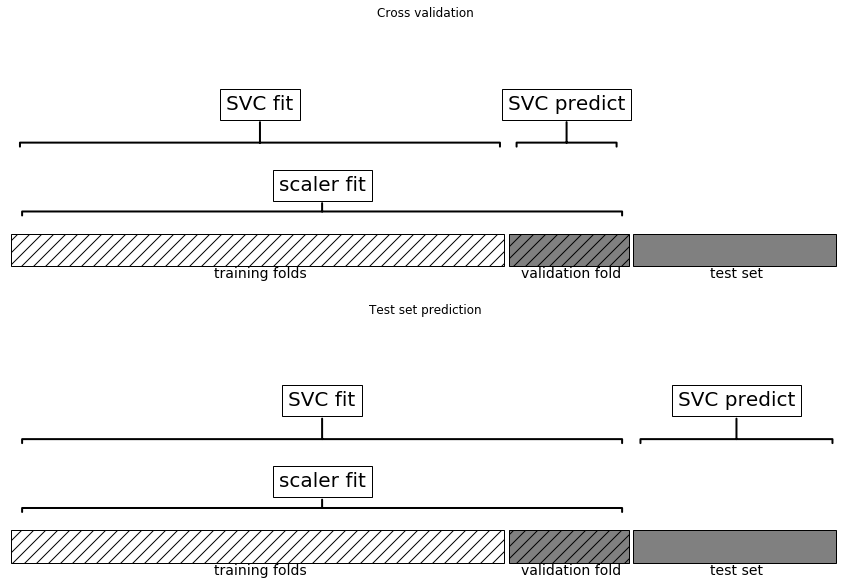

In [56]:
%matplotlib inline
import mglearn
#from preamble import *

mglearn.plots.plot_improper_processing()

In [53]:
! pip install mglearn

  Created wheel for mglearn: filename=mglearn-0.1.7-py2.py3-none-any.whl size=582711 sha256=e1ef2a946f64fc720008914c879263c0748bc0987a420b62ebbffe55e3d7efd9
  Stored in directory: C:\Users\USER\AppData\Local\pip\Cache\wheels\74\cf\8d\04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


### 파이프라인 구축

In [19]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [20]:
pipe.fit(X_train, y_train)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [21]:
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))


### pipline.score 의 value는 Accuracy 인가 ? 

테스트 점수: 0.95


### Grid Search - Pipline 적용

In [22]:
### Pipline - GridSearch를 할때 parameter 설정시에는 앞예 단계 이름__파리미터명 ex. 'model__C' 라고 명 해줘야함

param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [23]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수:", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


*정보 누설에 대한 좋은 예시
*책 The elements of statistical learning 에 교차 검증의 정보 누설에 대한 좋은예가 잇음. 이 책은 통계학 전공자들이 머신러닝에 대해 보기 좋은 책

In [24]:
import numpy as np

rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [25]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape:", X_selected.shape)

X_selected.shape: (100, 500)


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("교차 검증 점수 (릿지): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수 (릿지): 0.91


In [27]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("교차 검증 점수 (파이프라인): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 점수 (파이프라인): -0.25


*위 예제에서 파이프라인을 사용하게 되면 특성선택이 교차검증 반복안으로 들어가게 되면서 훈련 폴드 사용해서만 특성선택이 되었고 테스트 폴드는 전혀 사용되지 않아 연관성이 없는 모델을 fitting하다 보니 r2 낮아질수 밖에 없다.. 

### Pipeline Interface

In [28]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [29]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다
    return self.steps[-1][1].predict(X_transformed)

**make pipeline 사용**

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [32]:
### make_pipeline을 이용하면 name 지정을 하지 않아도 자동으로 할당. 
print("파이프라인 단계:\n", pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n", pipe.steps)

# 동일 클래스 이름은 뒤에 숫자로 순차대로 부여 

파이프라인 단계:
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


**단계에 접근해보기

In [34]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출합니다
components = pipe.named_steps["pca"].components_
print("components.shape:", components.shape)

components.shape: (2, 30)


**그리드 서치 안에서 파이프라인 속성 접근해보기

In [35]:
from sklearn.linear_model import LogisticRegression

### 간단한 pipeline 생성, make pipemline을 이용했기 때문에 class name은 class 소문자
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [36]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)

### logistic 'C' value에 따른 최적의 모델 찾기
grid = GridSearchCV(pipe, param_grid, cv=5)

grid.fit(X_train, y_train)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                     

In [38]:
### 최상의 모델 바로 추출
print("최상의 모델:\n", grid.best_estimator_)

최상의 모델:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [39]:
### 파이프 라인 접근해보기
print("로지스틱 회귀 단계:\n",
      grid.best_estimator_.named_steps["logisticregression"])

로지스틱 회귀 단계:
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [40]:
print("로지스틱 회귀 계수:\n",
      grid.best_estimator_.named_steps["logisticregression"].coef_)

로지스틱 회귀 계수:
 [[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


## 전처리와 모델의 매개변수를 위한 그리도 서치

In [70]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [71]:
### parameter 각 각 class 별로
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [72]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

**heatmap 그리기

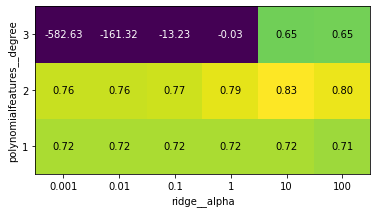

In [73]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1), 
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree", 
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [65]:
print(param_grid['ridge__alpha'])

[0.001, 0.01, 0.1, 1, 10, 100]


In [45]:
print("최적의 매개변수:", grid.best_params_)

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [46]:
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

테스트 세트 점수: 0.77


In [47]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 모델 선택을 위한 그리드서치

In [48]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [49]:
from sklearn.ensemble import RandomForestClassifier

### 각 모델에 필요한 전처리를 개별로 지정 
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


**중복계산 피하기 (캐싱)

In [51]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")

**계산 비용이 높은 파이프라인과 방대한 양의 매개변수를 탐색을 해야한다면 dask-ml 라이브러리를 이용.
- 캐시는 디스크에 저장되어 관리되기 때문에 실제 디스크에 읽고 쓰기 위해 직렬화가 필요
- 즉, 비교적 오래 걸리는 변환이어야 memory 매개변수를 사용하여 속도를 높이는 효과를 낼 수 있다..
- 또한 n_jobs 매개변수가 캐싱을 방해한다는 단점이 존재. 최악의 경우 캐시되기전에 n_jobs 만큼의 작업 프로세스가 동시에 동일한 계산을 중복으로 수행 할 수도 있음

- https://dask-ml.readthedocs.io/en/latest/